In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# Define a transform to normalize the data. The transforms are applied
# in the order they are given. First, the image is converted to a tensor,
# then it is normalized with mean and standard deviation of 0.5 for all channels.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download the CIFAR-10 dataset, apply the transforms, and load it into
# a DataLoader for efficient batch processing and shuffling.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

# Define the classes in the CIFAR-10 dataset. These correspond to the labels
# of the images in the dataset.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load the pretrained ResNet-50 model.
net = models.resnet50(pretrained=True)

# Freeze all the parameters of the model, making them untrainable.
# This is done because we want to keep the weights of the pre-trained model
# and only train the final layer that we will add next.
for param in net.parameters():
    param.requires_grad = False

# Replace the last fully connected layer of the model with a new one 
# having the correct number of output features. The new layer's parameters
# are not frozen, so they will be learned during training.
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

# Define a loss function and an optimizer. The loss function is used to measure
# how well the model's predictions match the actual labels, and the optimizer
# is used to update the model's parameters based on this loss.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device (GPU or CPU)
net.to(device)

# Training loop
for epoch in range(5):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        # Move the inputs and labels to the device
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        # This is necessary because by default, gradients are accumulated
        # in backward passes, so we need to clear them at each step
        optimizer.zero_grad()

        # Forward pass: compute the outputs by passing inputs to the model
        outputs = net(inputs)
        # Compute the loss between the outputs and the ground truth labels
        loss = criterion(outputs, labels)
        # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
        loss.backward()
        # Perform an optimization step: update the model's parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # Print every 2000 mini-batches
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# After training, we want to test how well the model performs on unseen data
# We'll compute the accuracy of the model on the test data

correct = 0
total = 0
# We don't need to compute gradients during testing, so we use torch.no_grad() 
# to disable gradient computation
with torch.no_grad():
    for data in testloader:
        # Get the inputs; data is a list of [inputs, labels]
        # Move the inputs and labels to the device
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass: compute the outputs by passing inputs to the model
        outputs = net(images)
        # Get the predicted class by finding the maximum value 
        # (since we're using CrossEntropyLoss)
        _, predicted = torch.max(outputs.data, 1)
        # Update the total number of images
        total += labels.size(0)
        # Update the number of correctly predicted images
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# We will store the vectors in a Python dictionary. 
# The keys will be the image labels and the values will be the vectors.
vectors = {}

# We move the model to the CPU for the feature extraction. 
# This is because we're going to be working with numpy, which can't handle CUDA tensors.
net = net.to('cpu')

# We don't need to compute gradients during feature extraction, 
# so we use torch.no_grad() to disable gradient computation.
with torch.no_grad():
    for data in trainloader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data
        # Forward pass: compute the outputs by passing inputs to the model
        outputs = net(images)
        # For each image in the batch, we store its vector in the dictionary.
        for i in range(len(outputs)):
            vectors[labels[i].item()] = outputs[i].numpy()


In [1]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the ResNet-50 model architecture
net = models.resnet50(pretrained=False)  # Note: pretrained is set to False

# Modify the final layer to match CIFAR-10's 10 classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

# Load the saved model weights
saved_weights_path = "C:/Users/Malco/OneDrive/Desktop/Vector Database Project/cifar_net.pth"
net.load_state_dict(torch.load(saved_weights_path))

print("Model loaded successfully!")


c:\Users\Malco\mambaforge\envs\data\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Malco\mambaforge\envs\data\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


Files already downloaded and verified


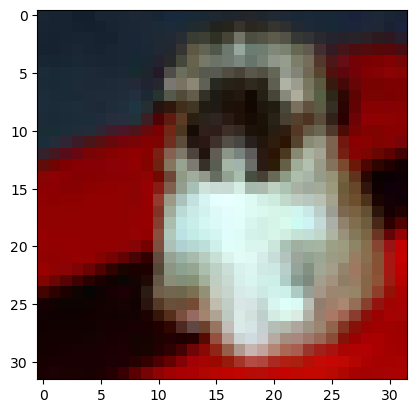

Label: dog


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# Get a random image
dataiter = iter(trainloader)
image, label = next(dataiter)

# Function to show image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.show()

# Display the image
imshow(image[0])

print("Label:", trainset.classes[label[0]])


In [7]:
image_vector = image.view(-1)

torch.save(image_vector, 'cifar_vector.pth')


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import pickle

# 1. Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# 2. Set up the ResNet-50 model structure
net = models.resnet50(pretrained=False)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

# 3. Load the saved model weights and move the model to the device
weights_path = "cifar_net.pth"
net.load_state_dict(torch.load(weights_path))
net.to(device)
print("Model weights loaded successfully and moved to device!")

# 4. Extract feature vectors for all images in the dataset
vectors = {label: [] for label in range(10)}

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        outputs = outputs.cpu()
        for i in range(len(outputs)):
            label = labels[i].item()
            vectors[label].append(outputs[i].numpy())

# Check the number of vectors extracted for each class
for label, vecs in vectors.items():
    print(f"Extracted {len(vecs)} feature vectors for class {label}.")

# 5. Serialize and save the 'vectors' dictionary
with open("vectors.pkl", "wb") as f:
    pickle.dump(vectors, f)

print("Feature vectors serialized and saved successfully!")


Files already downloaded and verified
Running on device: cuda:0
Model weights loaded successfully and moved to device!
Extracted 5000 feature vectors for class 0.
Extracted 5000 feature vectors for class 1.
Extracted 5000 feature vectors for class 2.
Extracted 5000 feature vectors for class 3.
Extracted 5000 feature vectors for class 4.
Extracted 5000 feature vectors for class 5.
Extracted 5000 feature vectors for class 6.
Extracted 5000 feature vectors for class 7.
Extracted 5000 feature vectors for class 8.
Extracted 5000 feature vectors for class 9.
Feature vectors serialized and saved successfully!


In [16]:
import h5py
import numpy as np

# Assuming you have 'all_vectors' from the previous extraction step

# 1. Organize the data for serialization
labels = [vec[0] for vec in all_vectors]
vectors = [vec[1] for vec in all_vectors]
labels_array = np.array(labels)
vectors_array = np.array(vectors)

# 2. Serialize the feature vectors using HDF5
with h5py.File('vectors.h5', 'w') as hf:
    hf.create_dataset("labels", data=labels_array)
    hf.create_dataset("vectors", data=vectors_array)

print("Feature vectors serialized and saved to vectors.h5!")


Feature vectors serialized and saved to vectors.h5!


In [6]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# 1. Load a random CIFAR-10 image
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)  # Ensure batch size is 1
dataiter = iter(trainloader)
single_image, single_label = next(dataiter)


# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Set up the ResNet-50 model structure and load weights
net_single = models.resnet50(pretrained=False)
num_ftrs_single = net_single.fc.in_features
net_single.fc = nn.Linear(num_ftrs_single, 10)
weights_path = "cifar_net.pth"  # Assuming the path to your model weights
net_single.load_state_dict(torch.load(weights_path))
net_single.to(device)
net_single.eval()

# Extract the feature vector for the single image
with torch.no_grad():
    single_image = single_image.to(device)
    single_output = net_single(single_image)
    single_vector = single_output.cpu().numpy()

print(single_vector)  # This is the extracted feature vector for your single CIFAR-10 image


Files already downloaded and verified
[[-3.7416759   1.5174972   0.4495462   0.9992044   0.5351528  -1.2945983
   2.1852105   4.914448   -0.97608423  0.26909238]]


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import h5py
import numpy as np

# 1. Load the feature vectors from 'vectors.h5'
with h5py.File('vectors.h5', 'r') as hf:
    labels_h5 = hf['labels'][:]
    vectors_h5 = hf['vectors'][:]

# 2. Compute the cosine similarity for the single_vector against each feature vector in 'vectors.h5'
similarities_h5 = cosine_similarity(single_vector, vectors_h5)

# 3. Determine the Most Similar Image
most_similar_index_h5 = np.argmax(similarities_h5)
most_similar_label_h5 = labels_h5[most_similar_index_h5]
most_similar_value_h5 = similarities_h5[0][most_similar_index_h5]

print(most_similar_label_h5, most_similar_value_h5)


7 0.9999587
